In [1]:
import torch

from pulser_diff.pulser import Sequence, Pulse, Register
from pulser_diff.pulser.devices import MockDevice
from pulser_diff.pulser.waveforms import BlackmanWaveform, RampWaveform

import pulser_diff.dq as dq
from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param
from pulser_diff.model import QuantumModel

from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy import interpolate

### Toy optimization problem

In [2]:
# create register
reg = Register.rectangle(1, 2, spacing=8, prefix="q")

In [3]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

In [4]:
# define pulse parameters
omega = torch.tensor([5.0], requires_grad=True)
area = torch.tensor([torch.pi], requires_grad=True)

In [5]:
# declare sequence variables
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

In [6]:
# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

In [7]:
# create quantum model from sequence
trainable_params = {"omega": omega, "area": area}
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver="krylov")

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.area
Parameter containing:
tensor([3.1416], requires_grad=True)
-------
trainable_params.omega
Parameter containing:
tensor([5.], requires_grad=True)
-------


In [8]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [9]:
# print initial expectation value as a result of simulating initial sequence
_, init_exp_val = model.expectation()
print("Initial expectation value:", init_exp_val[-1])
print()

# optimize model parameters so that the final output expectation value matches the predefined value
epochs = 20
target_value = torch.tensor(-0.5)
for t in range(epochs):
    # calcualte prediction and loss
    evaluation_times, exp_val = model.expectation()
    loss = loss_fn(exp_val.real[-1], target_value)

    # backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # update sequence with changed pulse parameter values
    model.update_sequence()

    print(f"loss: {loss:>7f}")

# print expectation value with optimized model
_, init_exp_val = model.expectation()
print()
print("Optimized expectation value:", init_exp_val[-1])
print()

Initial expectation value: tensor(-1.2782+0.j, grad_fn=<SelectBackward0>)

loss: 0.605560
loss: 0.433920
loss: 0.252128
loss: 0.119507
loss: 0.050335
loss: 0.020542
loss: 0.008450
loss: 0.003535
loss: 0.001501
loss: 0.000645
loss: 0.000280
loss: 0.000122
loss: 0.000053
loss: 0.000023
loss: 0.000010
loss: 0.000005
loss: 0.000002
loss: 0.000001
loss: 0.000000
loss: 0.000000

Optimized expectation value: tensor(-0.5003+0.j, grad_fn=<SelectBackward0>)



We can print the optimized values of amplitude of the constant pulse `omega` and the area of the Blackman pulse `area`:

In [10]:
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')


trainable_params.area
Parameter containing:
tensor([2.7814], requires_grad=True)
-------
trainable_params.omega
Parameter containing:
tensor([4.4623], requires_grad=True)
-------


The values of both parameters were optimized in order to minimize the provided loss function

### QUBO problem solution with QAOA

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pulser_diff.pulser import Pulse, Sequence, Register
from pulser_diff.pulser_simulation import QutipEmulator
from pulser_diff.pulser.devices import Chadoq2
from pulser_diff.pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [12]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809],
        [19.7365809, -10.0, 20.67626392],
        [19.7365809, 20.67626392, -10.0],
    ]
)

In [13]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('001', -10.0), ('010', -10.0), ('100', -10.0)]


In [14]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

In [15]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

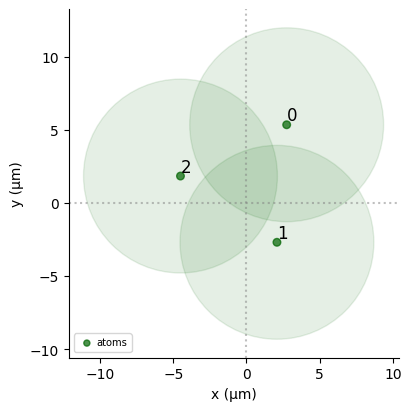

In [16]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [17]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
pulse_2 = Pulse.ConstantPulse(1000, 0.0, 1.0, 0)
seq.add(pulse_2, "ch0")

print(seq)

simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
results = simul.run()

Channel: ch0
t: 0 | Initial targets: 0, 1, 2 | Phase Reference: 0.0 
t: 0->1000 | Detuned Delay | Detuning: 1 rad/µs




/tmp/ipykernel_46639/3049915425.py:1: DeprecationWarning: The 'Chadoq2' device has been deprecated. For a similar device combining global and local addressing, consider using `DigitalAnalogDevice`.
  seq = Sequence(reg, Chadoq2)


In [18]:
ham = simul.get_hamiltonian(0).full()
np.linalg.eig(ham)

(array([57.14942062+0.j, 17.73658172+0.j, 17.7365796 +0.j, -1.        +0.j,
        18.67625931+0.j, -1.        +0.j, -1.        +0.j,  0.        +0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

In [19]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

variables_amp = {f"omega{i}": seq.declare_variable(f"omega{i}") for i in range(LAYERS)}
variables_det = {f"det{i}": seq.declare_variable(f"det{i}") for i in range(LAYERS)}

for amp, det in zip(variables_amp.items(), variables_det.items()):
    pulse_1 = Pulse.ConstantPulse(500, amp[1], 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(500, 0.0, det[1], 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

/tmp/ipykernel_46639/2349451885.py:4: DeprecationWarning: The 'Chadoq2' device has been deprecated. For a similar device combining global and local addressing, consider using `DigitalAnalogDevice`.
  seq = Sequence(reg, Chadoq2)


In [20]:
print(seq)

Prelude
-------
Channel: ch0
t: 0 | Initial targets: 0, 1, 2 | Phase Reference: 0.0 

Stored calls
------------

1. add(Pulse(ConstantWaveform(500, omega0[0]), 0 rad/µs, 0, 0.0), ch0)

2. add(Pulse(0 rad/µs, ConstantWaveform(500, det0[0]), 0, 0.0), ch0)

3. add(Pulse(ConstantWaveform(500, omega1[0]), 0 rad/µs, 0, 0.0), ch0)

4. add(Pulse(0 rad/µs, ConstantWaveform(500, det1[0]), 0, 0.0), ch0)

5. measure(ground-rydberg)


In [21]:
trainable_params = {}
values_amp = {f"omega{i}": torch.tensor([1.0], requires_grad=True) for i in range(LAYERS)}
values_det = {f"det{i}": torch.tensor([1.0], requires_grad=True) for i in range(LAYERS)}
trainable_params.update(values_amp)
trainable_params.update(values_det)
model = QuantumModel(seq, trainable_params, sampling_rate=0.5, solver="krylov")

In [22]:
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('----------')


trainable_params.det0
Parameter containing:
tensor([1.], requires_grad=True)
----------
trainable_params.det1
Parameter containing:
tensor([1.], requires_grad=True)
----------
trainable_params.omega0
Parameter containing:
tensor([1.], requires_grad=True)
----------
trainable_params.omega1
Parameter containing:
tensor([1.], requires_grad=True)
----------


In [23]:
obs = model._sim.get_hamiltonian(600).to_dense().detach()
obs

tensor([[57.1494+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j, 17.7366+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j, 17.7366+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -1.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, 18.6763+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -1.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
         -1.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j]])

In [24]:
model.expectation(obs)[1][-1]

tensor(-0.4199+0.j, grad_fn=<SelectBackward0>)

In [25]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [26]:
epochs = 20
for t in range(epochs):
    # Compute prediction and loss
    evaluation_times, exp_val = model.expectation(obs)
    loss = exp_val.real[-1]
    # loss = loss_fn(exp_val.real[-1], torch.tensor(0.0))

    x = evaluation_times.detach().numpy()
    y = exp_val.real.detach().numpy()


    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    model.update_sequence()

    print(f"loss: {loss}")

loss: -0.4199307933809058
loss: -0.42651164277832854
loss: -0.4323683141350725
loss: -0.4375709675021262
loss: -0.4421893622539042
loss: -0.4462908834137078
loss: -0.44993912043018536
loss: -0.45319293308806613
loss: -0.45610592481971346
loss: -0.45872624036354426
loss: -0.4610966090049623
loss: -0.4632545635066585
loss: -0.46523277587867634
loss: -0.4670594626398092
loss: -0.46875882307516026
loss: -0.47035148356653667
loss: -0.47185492911679683
loss: -0.47328390965129247
loss: -0.4746508136945867
loss: -0.47596600576043024


In [27]:
torch.abs(model()[1][-1])**2

tensor([[3.5465e-06],
        [4.1475e-03],
        [4.1475e-03],
        [2.2674e-01],
        [3.0417e-03],
        [2.2732e-01],
        [2.2732e-01],
        [3.0729e-01]], grad_fn=<PowBackward0>)

In [28]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [29]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [30]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

/tmp/ipykernel_46639/1029010566.py:4: UserWarning: No declared variables named: s_list, t_list
  assigned_seq = seq.build(t_list=t_params, s_list=s_params)


TypeError: Did not receive values for variables: det0, det1, omega0, omega1

In [ ]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["001", "100", "010"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

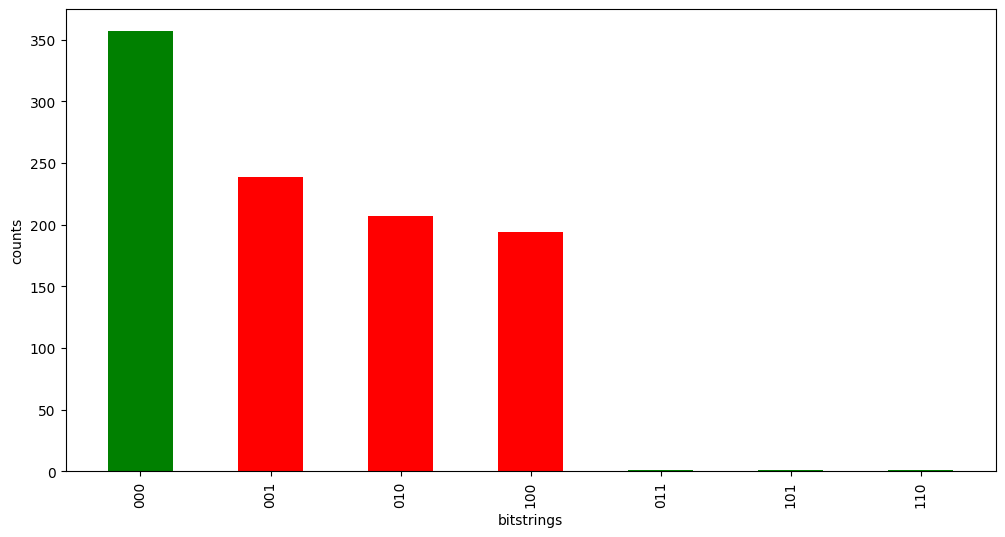

In [ ]:
plot_distribution(example_dict)

In [ ]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [ ]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [ ]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

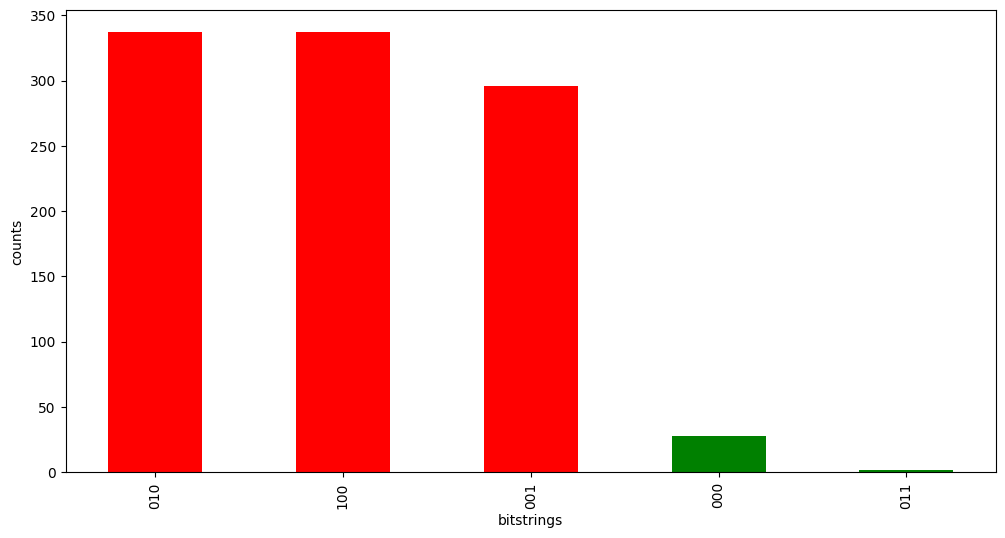

In [ ]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)